In [ ]:
%cd /ai-adulteration-detection

In [ ]:
import numpy as np
import os
from os.path import isfile
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Bidirectional, LSTM, Dropout, Activation, GRU
from keras.layers import Conv2D, concatenate, MaxPooling2D, Flatten, Embedding, Lambda
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras import backend as K
from keras.utils import np_utils
from keras.optimizers import Adam, RMSprop
from keras import regularizers
import librosa
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [ ]:
train_data_path = "./npz_files/shuffled_train_arr_MFCCs.npz"
train_data = np.load(train_data_path, allow_pickle = True)
arr_0_train = train_data['arr_0']
arr_1_train = train_data['arr_1']
print(arr_0_train.shape, arr_1_train.shape)

valid_data_path = "./npz_files/shuffled_valid_arr_MFCCs.npz"
valid_data = np.load(valid_data_path, allow_pickle = True)
arr_0_valid = valid_data['arr_0']
arr_1_valid = valid_data['arr_1']
print(arr_0_valid.shape, arr_1_valid.shape)

X = np.concatenate((arr_0_train, arr_0_valid))
y = np.concatenate((arr_1_train, arr_1_valid))
print(X.shape, y.shape)

(8010, 173, 40) (8010,)
(1001, 173, 40) (1001,)
(9011, 173, 40) (9011,)


In [ ]:
np.unique(y, return_counts = True)

(array([0, 1, 2, 3]), array([2222, 2271, 2266, 2252]))

### Parallel CNN-RNN MODEL

In [ ]:
def parallel_conv_recurrent_model_build(model_input):
    print('Building model...')
    layer = model_input
    
    ### Convolutional Blocks
    conv_1 = Conv2D(filters = nb_filters1, kernel_size = ksize, strides = 1,
                      padding = 'valid', activation = 'relu', name = 'conv_1')(layer)
    pool_1 = MaxPooling2D(pool_size_1)(conv_1)
    
    conv_2 = Conv2D(filters = nb_filters2, kernel_size = ksize, strides = 1,
                      padding = 'valid', activation = 'relu', name = 'conv_2')(pool_1)
    pool_2 = MaxPooling2D(pool_size_2)(conv_2)
    
    conv_3 = Conv2D(filters = nb_filters3, kernel_size = ksize, strides=1,
                      padding = 'valid', activation = 'relu', name = 'conv_3')(pool_2)
    pool_3 = MaxPooling2D(pool_size_3)(conv_3)
        
    flatten1 = Flatten()(pool_3)
    
    ### Recurrent Block
    
    # Pooling layer
    pool_lstm1 = MaxPooling2D(pool_size_4, name = 'pool_lstm')(layer)
    
    # Embedding layer
    squeezed = Lambda(lambda x: K.squeeze(x, axis = -1))(pool_lstm1)
    
    # Bidirectional GRU
    lstm = LSTM(LSTM_COUNT, return_sequences = False)(squeezed)
   
    ### Concat Output
    concat = concatenate([flatten1, lstm], axis = -1, name = 'concat')
    
    ### Dense Layer
    dense_layer = Dense(64, kernel_regularizer = regularizers.l2(0.001), name = 'dense1')(concat)
    drop_layer = Dropout(0.4)(dense_layer)

    ### Softmax Output
    output = Dense(num_classes, activation = 'softmax', name = 'preds')(drop_layer)
    
    model_output = output
    model = Model(model_input, model_output)
    
    opt = Adam(lr=0.001)
    model.compile(loss = 'categorical_crossentropy',
                  optimizer = opt,
                  metrics = ['accuracy'])
    
    print(model.summary())
    return model

In [ ]:
def train_model(x_train, y_train, x_val, y_val, fold_num):
    
    n_frequency = x_train.shape[2]
    n_frames = x_train.shape[1]

    x_train = np.expand_dims(x_train, axis = -1)
    
    x_val = np.expand_dims(x_val, axis = -1)
       
    input_shape = (n_frames, n_frequency, 1)
    model_input = Input(input_shape, name = 'input')
    
    model = parallel_conv_recurrent_model_build(model_input)
    
    model_filepath = "./models/Parallel_CNN_RNN_MFCCs_withCV_" + str(fold_num) + "_model.h5"
    checkpoint_callback = ModelCheckpoint(filepath = model_filepath, monitor = 'val_accuracy', verbose = 1,
                                          save_best_only = True, mode = 'max')
    
    reducelr_callback = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.5, patience = 10, min_delta = 0.01, verbose = 1)
    callbacks_list = [checkpoint_callback, reducelr_callback]

    # Fit the model and get training history
    print('Training...')
    history = model.fit(x_train, y_train, batch_size = BATCH_SIZE, epochs = EPOCH_COUNT,
                        validation_data = (x_val, y_val), verbose = 2, callbacks = callbacks_list)
    # verbose: 0, 1, or 2. Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.

    return model, history

### TRAINING WITH CROSS-VALIDATION

In [ ]:
# num_classes = np.amax(y) + 1
# n_features = X.shape[2]
# n_time = X.shape[1]

# nb_filters1 = 16 
# nb_filters2 = 32 
# nb_filters3 = 64
# ksize = (3, 1)
# pool_size_1 = (2, 2) 
# pool_size_2 = (2, 2)
# pool_size_3 = (2, 2)
# pool_size_4 = (2, 1)
# LSTM_COUNT = 96

# BATCH_SIZE = 64
# EPOCH_COUNT = 25

# from keras.utils import to_categorical
# from sklearn.model_selection import StratifiedKFold
# from datetime import datetime

# # K = 5
# skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 15)

# train_accuracy_arr = np.empty((0, EPOCH_COUNT))
# train_loss_arr = np.empty((0, EPOCH_COUNT))
# valid_accuracy_arr = np.empty((0, EPOCH_COUNT))
# valid_loss_arr = np.empty((0, EPOCH_COUNT))

# training_times = np.empty((0))

# fold_count = 0

# for train_index, valid_index in skf.split(X, y):
  
#   start = datetime.now()

#   fold_count += 1
#   print("Training on fold:", fold_count)
  
#   X_train = X[train_index]
#   X_valid = X[valid_index]
#   y_train = to_categorical(y[train_index], num_classes = 4)
#   y_valid = to_categorical(y[valid_index], num_classes = 4)
  
#   model, history  = train_model(X_train, y_train, X_valid, y_valid, fold_count) 
  
#   train_accuracy_arr = np.append(train_accuracy_arr, [history.history['accuracy']], axis = 0)
#   train_loss_arr = np.append(train_loss_arr, [history.history['loss']], axis = 0)
#   valid_accuracy_arr = np.append(valid_accuracy_arr, [history.history['val_accuracy']], axis = 0)
#   valid_loss_arr = np.append(valid_loss_arr, [history.history['val_loss']], axis = 0)

#   duration = datetime.now() - start
#   print("Training completed in time:", duration)

#   training_times = np.append(training_times, [duration])
  
#   X_valid = np.expand_dims(X_valid, axis = -1)
#   score = model.evaluate(X_valid, y_valid, verbose = 1)
#   accuracy = 100 * score[1]
#   print("Training accuracy for validation data: %.4f%%" %accuracy)

# %cd ./npz_files_results
# np.savez("training_times_MFCCs", training_times)
# np.savez("train_accuracy_arr_MFCCs", train_accuracy_arr)
# np.savez("train_loss_arr_MFCCs", train_loss_arr)
# np.savez("valid_accuracy_arr_MFCCs", valid_accuracy_arr)
# np.savez("valid_loss_arr_MFCCs", valid_loss_arr)
# %cd /ai-adulteration-detection

Training on fold: 1
Building model...
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 173, 40, 1)   0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 171, 40, 16)  64          input[0][0]                      
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 85, 20, 16)   0           conv_1[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv2D)                 (None, 83, 20, 32)   1568        max_pooling2d_1[0][0]            
______________________________________________________

### RESULTS

In [ ]:
# %cd ./npz_files_results
# train_accuracy = np.load("train_accuracy_arr_MFCCs.npz", allow_pickle = True)
# train_accuracy_arr = train_accuracy['arr_0']
# train_loss = np.load("train_loss_arr_MFCCs.npz", allow_pickle = True)
# train_loss_arr = train_loss['arr_0']
# valid_accuracy = np.load("valid_accuracy_arr_MFCCs.npz", allow_pickle = True)
# valid_accuracy_arr = valid_accuracy['arr_0']
# valid_loss = np.load("valid_loss_arr_MFCCs.npz", allow_pickle = True)
# valid_loss_arr = valid_loss['arr_0']
# %cd /ai-adulteration-detection
# EPOCH_COUNT = 25

In [ ]:
train_accuracy_mean = np.mean(train_accuracy_arr, axis = 0)
train_accuracy_std = np.std(train_accuracy_arr, axis = 0)
valid_accuracy_mean = np.mean(valid_accuracy_arr, axis = 0)
valid_accuracy_std = np.std(valid_accuracy_arr, axis = 0)

train_loss_mean = np.mean(train_loss_arr, axis = 0)
train_loss_std = np.std(train_loss_arr, axis = 0)
valid_loss_mean = np.mean(valid_loss_arr, axis = 0)
valid_loss_std = np.std(valid_loss_arr, axis = 0)

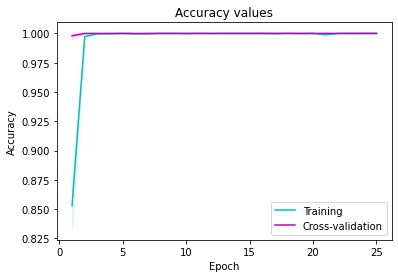

In [ ]:
# Plot accuracy curve
epochs = np.linspace(1, EPOCH_COUNT, EPOCH_COUNT)

plt.fill_between(epochs, train_accuracy_mean - train_accuracy_std,
                 train_accuracy_mean + train_accuracy_std, alpha = 0.1,
                 color = "c")
plt.fill_between(epochs, valid_accuracy_mean - valid_accuracy_std,
                 valid_accuracy_mean + valid_accuracy_std, alpha = 0.1,
                 color = "m")
   
plt.plot(epochs, train_accuracy_mean, color = "c",
         label = "Training")
plt.plot(epochs, valid_accuracy_mean, color = "m",
         label = "Cross-validation")

plt.title('Accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc = 'lower right')
plt.show()

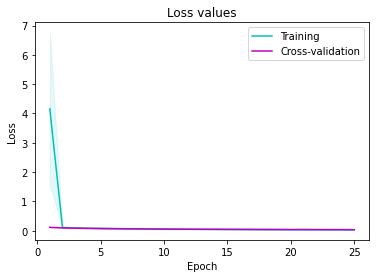

In [ ]:
# Plot loss curve
epochs = np.linspace(1, EPOCH_COUNT, EPOCH_COUNT)

plt.fill_between(epochs, train_loss_mean - train_loss_std,
                 train_loss_mean + train_loss_std, alpha = 0.1,
                 color = "c")
plt.fill_between(epochs, valid_loss_mean - valid_loss_std,
                 valid_loss_mean + valid_loss_std, alpha = 0.1,
                 color = "m")
   
plt.plot(epochs, train_loss_mean, color = "c",
         label = "Training")
plt.plot(epochs, valid_loss_mean, color = "m",
         label = "Cross-validation")

plt.title('Loss values')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc = 'upper right')
plt.show()

### TEST THE MODEL

In [ ]:
# Compile the model
num_classes = np.amax(y) + 1
n_features = X.shape[2]
n_time = X.shape[1]

nb_filters1 = 16 
nb_filters2 = 32 
nb_filters3 = 64
ksize = (3, 1)
pool_size_1 = (2, 2) 
pool_size_2 = (2, 2)
pool_size_3 = (2, 2)
pool_size_4 = (2, 1)
LSTM_COUNT = 96

BATCH_SIZE = 64
EPOCH_COUNT = 25

n_frequency = X.shape[2]
n_frames = X.shape[1]
    
input_shape = (n_frames, n_frequency, 1)
model_input = Input(input_shape, name = 'input')
    
model = parallel_conv_recurrent_model_build(model_input)

model.load_weights("./models/Parallel_CNN_RNN_MFCCs_withCV_1_model.h5") # select which model will be used

Building model...
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 173, 40, 1)   0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 171, 40, 16)  64          input[0][0]                      
__________________________________________________________________________________________________
max_pooling2d_16 (MaxPooling2D) (None, 85, 20, 16)   0           conv_1[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv2D)                 (None, 83, 20, 32)   1568        max_pooling2d_16[0][0]           
__________________________________________________________________________

In [ ]:
test_data_path = "/npz_files/shuffled_test_arr_MFCCs.npz"
test_data = np.load(test_data_path, allow_pickle = True)
arr_0_test = test_data['arr_0']
arr_1_test = test_data['arr_1']

X_test = arr_0_test
print(X_test.shape) 
from keras.utils import to_categorical
y_test = to_categorical(arr_1_test)
print(y_test.shape)

(1002, 173, 40)
(1002, 4)


In [ ]:
np.unique(arr_1_test, return_counts = True)

(array([0, 1, 2, 3]), array([268, 236, 243, 255]))

In [ ]:
X_test = np.expand_dims(X_test, axis = -1)
score = model.evaluate(X_test, y_test, verbose = 1)
accuracy = 100 * score[1]
print("Training accuracy for test data: %.4f%%" %accuracy)

1002/1002 [==============================] - 1s 955us/step
Training accuracy for test data: 100.0000%


In [ ]:
dict_classes = {"Cheese":0, "Empty":1, "NonorganicButter":2, "OrganicButter":3}

y_true = np.argmax(y_test, axis = 1)

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)

target_names = dict_classes.keys()

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred, target_names=target_names))
print(confusion_matrix(y_true, y_pred))

                  precision    recall  f1-score   support

          Cheese       1.00      1.00      1.00       268
           Empty       1.00      1.00      1.00       236
NonorganicButter       1.00      1.00      1.00       243
   OrganicButter       1.00      1.00      1.00       255

        accuracy                           1.00      1002
       macro avg       1.00      1.00      1.00      1002
    weighted avg       1.00      1.00      1.00      1002

[[268   0   0   0]
 [  0 236   0   0]
 [  0   0 243   0]
 [  0   0   0 255]]


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


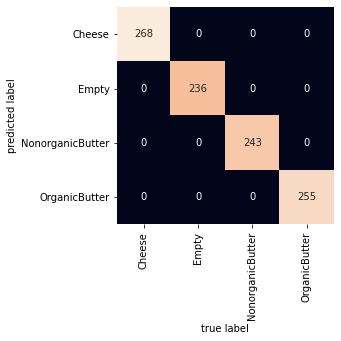

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

mat = confusion_matrix(y_true, y_pred)
sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False,
            xticklabels = dict_classes.keys(),
            yticklabels = dict_classes.keys())
plt.xlabel('true label')
plt.ylabel('predicted label');